In [193]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import *
import cv2 
from wordcloud import WordCloud

In [194]:
df_transfer_news=pd.read_csv("90minFootballTransferNewsNLP.csv")

In [195]:
df_transfer_news.head()

,Title,Date,Link,Content
0,Football transfer rumours: Why Maguire's Man U...,"Aug 15, 2023",https://www.90min.com/posts/football-transfer-...,"90minÂ rounds up the latestÂ transfer news, ru..."
1,Chelsea agree Romeo Lavia fee with Southampton,"Aug 15, 2023",https://www.90min.com/posts/chelsea-agree-rome...,Chelsea have finalised an agreement with South...
2,Harry Maguire's proposed West Ham transfer col...,"Aug 15, 2023",https://www.90min.com/posts/harry-maguire-prop...,Harry Maguire's proposed transfer to West Ham ...
3,Southampton director breaks down Chelsea & Liv...,"Aug 15, 2023",https://www.90min.com/posts/southampton-direct...,Southampton director Jason Wilcox has revealed...
4,Neymar completes move from PSG to Al Hilal,"Aug 15, 2023",https://www.90min.com/posts/neymar-completes-m...,Saudi Pro League side Al Hilal have confirmed ...


## Labelling

### Text blob

In [196]:
def polarity(text):
    text=text.lower()
    text=TextBlob(text)
    text=text.sentiment.polarity
    return text

In [197]:
df_transfer_news["Polarity"]=df_transfer_news["Title"].apply(polarity)

In [198]:
def labelling(polarity):
    if polarity >=1:
        return "Positive"
    if polarity >=0:
        return "Neutral"
    if polarity <0:
        return "Negative"


In [199]:
df_transfer_news=df_transfer_news[["Title","Polarity"]]

In [200]:
df_transfer_news["Sentiment"]=df_transfer_news["Polarity"].apply(labelling)

In [201]:
df_transfer_news.head(5)

,Title,Polarity,Sentiment
0,Football transfer rumours: Why Maguire's Man U...,0.000000,Neutral
1,Chelsea agree Romeo Lavia fee with Southampton,0.000000,Neutral
2,Harry Maguire's proposed West Ham transfer col...,0.000000,Neutral
3,Southampton director breaks down Chelsea & Liv...,-0.155556,Negative
4,Neymar completes move from PSG to Al Hilal,0.000000,Neutral


In [202]:
df_transfer_news.Sentiment.unique()

array(['Neutral', 'Negative', 'Positive'], dtype=object)

Vader Sentiment (not use)

In [203]:
# analyzer = SentimentIntensityAnalyzer()
# def labelling(text):
#     text=text.lower()
#     text=analyzer.polarity_scores(text)
#     text.pop('compound')
#     text=max(text,key=text.get)
#     return text

# EDA

In [204]:
style_counts_sentiments=df_transfer_news["Sentiment"].value_counts().reset_index().rename(columns={"index":"Sentiment","Sentiment":"Total sentiment"})

In [205]:
style_counts_sentiments

,Sentiment,Total sentiment
0,Neutral,6327
1,Negative,362
2,Positive,37


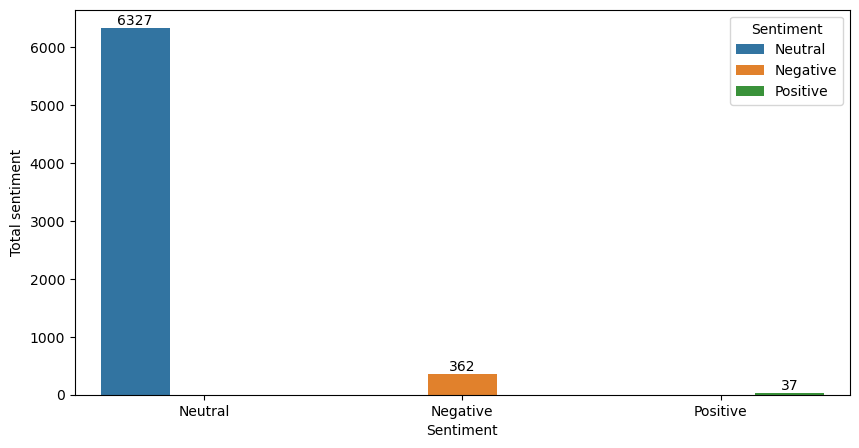

In [206]:
plt.figure(figsize=(10,5))
ax= sns.barplot(data=style_counts_sentiments,x="Sentiment",y="Total sentiment",hue="Sentiment")
for i in ax.containers:
                 ax.bar_label(i,)
plt.show()

The label imbalanced data
* Neutral total 6327
* Negative total 362
* Positive total 37

Handling Imbalance data

Combining over- and under-sampling.

In [207]:
from sklearn.utils import resample

In [208]:
df_majority=df_transfer_news[df_transfer_news["Sentiment"]=="Neutral"] # Under-sampling the majority class(es)
df_minority_negative=df_transfer_news[df_transfer_news["Sentiment"]=="Negative"] # Over-sampling the minority class.
df_minority_netral=df_transfer_news[df_transfer_news["Sentiment"]=="Positive"] # Over-sampling the minority class.

In [209]:
df_upscaled_minority_negative=resample(df_minority_negative,
                                       replace=True,
                                       n_samples=6327)
df_upscaled_minority_neutral=resample(df_minority_netral,
                                       replace=True,
                                       n_samples=6327)

In [210]:
df_upsampled_transfes_news = pd.concat([df_majority,df_upscaled_minority_negative,df_upscaled_minority_neutral ])

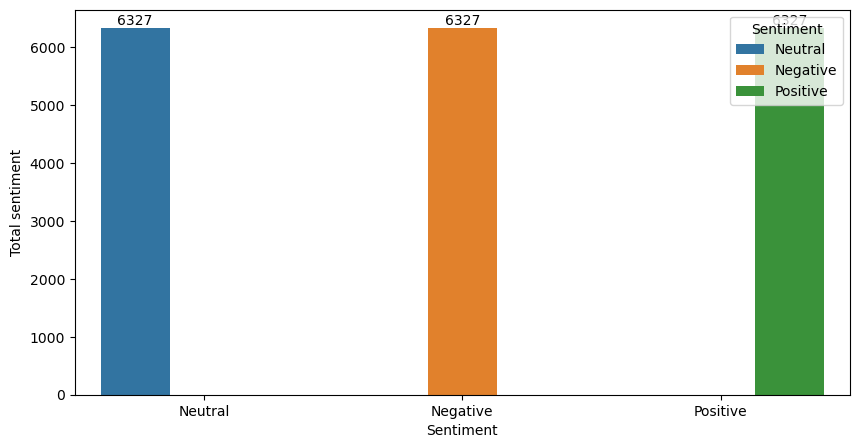

In [211]:
style_counts_sentiments=df_upsampled_transfes_news["Sentiment"].value_counts().reset_index().rename(columns={"index":"Sentiment","Sentiment":"Total sentiment"})
plt.figure(figsize=(10,5))
ax= sns.barplot(data=style_counts_sentiments,x="Sentiment",y="Total sentiment",hue="Sentiment")
for i in ax.containers:
                 ax.bar_label(i,)
plt.show()

# Preprocessing

In [212]:
def caseFolding(text):
  text=text.lower()
  return text


import re
def punc_removal(text):
  text=re.sub(r"[^a-zA-Z]"," ",text)
  return text

# import StemmerFactory class

# create stemmer
stemmer = PorterStemmer()
def stemsWords(text):
  text=stemmer.stem(text)
  return text

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('stopwords')
stp=stopwords.words('english')

def flatten(l):
    """
    Same as
    flat_list = []
    for sublist in l:
    for item in sublist:
        flat_list.append(item)

    Example =[[1,2,3,4,5]] - > [1,2,3,4,5]
    """
    return " ".join([item for sublist in l for item in sublist])

def remove_stop_words(text):
  clean_words = []
  text=text.split()
  perulangan_text=[word for word in text if word not in stp]
  clean_words.append(perulangan_text)
  return flatten(clean_words)

def preprocessing_text(text):
  text=caseFolding(text)
  text=punc_removal(text)
  text=remove_stop_words(text)
  text=stemsWords(text)
  return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Reza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Reza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [213]:
df_upsampled_transfes_news["Clean title"]=df_upsampled_transfes_news["Title"].apply(preprocessing_text)

In [214]:
df_transfer_news_update=df_upsampled_transfes_news[["Clean title","Sentiment"]]

# Wordcloud

In [215]:
# WordCloud Label negatif data pakaian
originalImage = cv2.imread('cloud.jpg')
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
(thresh, cloud_mask) = cv2.threshold(grayImage, 100, 255, cv2.THRESH_BINARY)

def word_cloud(data,clean_columns_data,columnsTargetLabel,label):
  
  data_target = data[data[columnsTargetLabel] == label]
  string_label = []

  for t in data_target[clean_columns_data]:
    string_label .append(t)

  string_label = pd.Series(string_label).str.cat(sep=' ')

  wordcloud = WordCloud(width=1600, height=800, margin=10,
                        background_color='white', colormap='Dark2',
                        max_font_size=200, min_font_size=25,
                        mask=cloud_mask, contour_width=10, contour_color='firebrick',
                        max_words=100).generate(string_label)
  plt.figure(figsize=(10,8))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.title(label)
  plt.show()

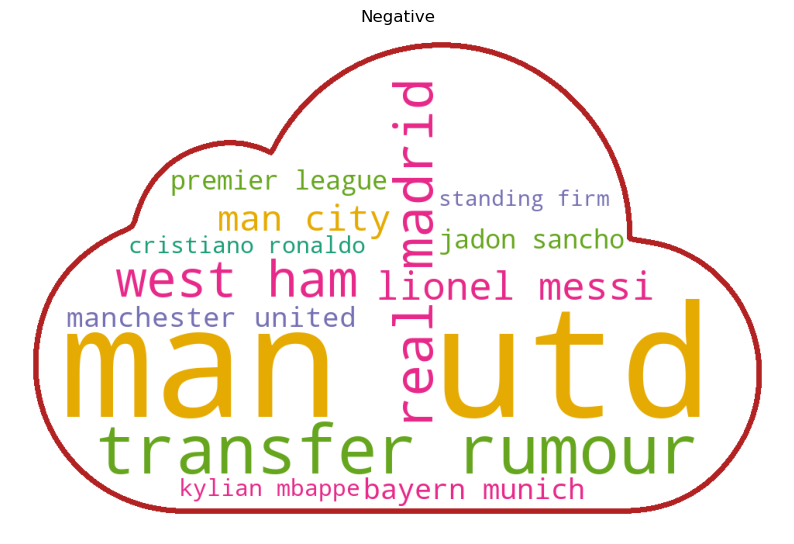

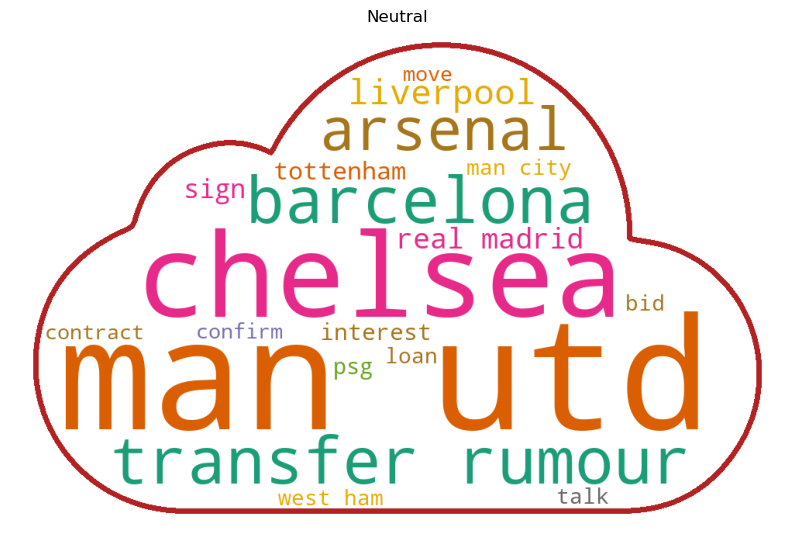

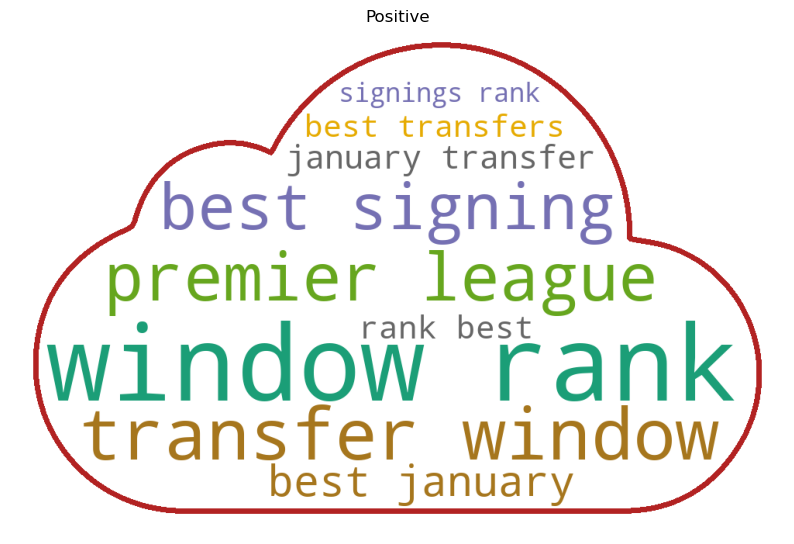

In [216]:
import numpy as np
label_string=[]
for label in df_transfer_news_update["Sentiment"]:
    label_string.append(label)
for label in np.unique(label_string):
            word_cloud(data=df_transfer_news_update,
            clean_columns_data="Clean title",
            columnsTargetLabel="Sentiment",
            label=(label))

# TFIDF

In [217]:
korpus=df_transfer_news_update["Clean title"]

In [218]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [219]:
vectorizer = TfidfVectorizer()
tfidf_transfer_news_title = vectorizer.fit_transform(korpus)

In [220]:
tfidf_transfer_news_title.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [221]:
korpus_unigram=tfidf_transfer_news_title.toarray()
data_unigram_vectorizer = pd.DataFrame(korpus_unigram, columns=vectorizer.get_feature_names_out())
data_unigram_vectorizer

,aanholt,aarhu,aaron,aarons,aaronson,abandon,abandoned,abby,abdallah,abdoulaye,...,zinchenko,zinedine,zion,ziyech,zlatan,zorc,zouma,zquez,zubimendi,zurich
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18976,0.0,0.0,0.0,0.366169,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18977,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18978,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18979,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [222]:
matrces_indices_tf = pd.DataFrame(korpus_unigram.T,
                              index=vectorizer.get_feature_names_out(),
                            columns=[f'D{i+1}' for i in range(len(df_transfer_news_update["Clean title"]))])
matrces_indices_tf.head()
data_tfidf_title_transfers_news=matrces_indices_tf.stack().reset_index()

In [223]:
data_tfidf_title_transfers_news=data_tfidf_title_transfers_news.rename(columns={0:'tfidf', 'level_0': 'term','level_1': 'Dokument'})

In [224]:
data_tfidf_title_transfers_news

,term,Dokument,tfidf
0,aanholt,D1,0.0
1,aanholt,D2,0.0
2,aanholt,D3,0.0
3,aanholt,D4,0.0
4,aanholt,D5,0.0
...,...,...,...
95797102,zurich,D18977,0.0
95797103,zurich,D18978,0.0
95797104,zurich,D18979,0.0
95797105,zurich,D18980,0.0


In [225]:
vectorizer.vocabulary_

{'football': 1684,
 'transfer': 4604,
 'rumours': 3941,
 'maguire': 2723,
 'man': 2749,
 'utd': 4759,
 'exit': 1494,
 'collapsed': 894,
 'liverpool': 2634,
 'six': 4179,
 'midfielder': 2895,
 'target': 4457,
 'chelsea': 814,
 'agree': 90,
 'romeo': 3895,
 'lavia': 2532,
 'fee': 1597,
 'southampton': 4236,
 'harry': 1980,
 'proposed': 3540,
 'west': 4910,
 'ham': 1963,
 'collaps': 892,
 'neymar': 3104,
 'completes': 931,
 'move': 3002,
 'psg': 3555,
 'al': 118,
 'hil': 2039,
 'moises': 2954,
 'caicedo': 695,
 'compares': 919,
 'expensive': 1502,
 'signings': 4156,
 'histori': 2047,
 'closing': 880,
 'michael': 2887,
 'olise': 3186,
 'sign': 4147,
 'seals': 4054,
 'loan': 2642,
 'brighton': 634,
 'ceo': 776,
 'admits': 67,
 'surprise': 4398,
 'snub': 4197,
 'kepa': 2414,
 'arrizabalaga': 290,
 'reveals': 3828,
 'desire': 1195,
 'seal': 4052,
 'permanent': 3345,
 'real': 3674,
 'madrid': 2714,
 'transf': 4603,
 'arsenal': 292,
 'confirm': 951,
 'signing': 4155,
 'david': 1096,
 'raya': 36

In [226]:
import pickle
pickle.dump(vectorizer.vocabulary_,open("tfidf/feature_tf-idf.pkl","wb"))

In [227]:
from sklearn.model_selection import train_test_split

# Modelling

In [228]:
X_tfidf_title=tfidf_transfer_news_title.toarray()
y_label=df_transfer_news_update["Sentiment"]

In [229]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_title, y_label, test_size=0.33, random_state=42)

In [230]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,classification_report

`Elbow method` <br>
to find best K value when use K nearest Neighbor

In [231]:
# code from https://medium.com/@moussadoumbia_90919/elbow-method-in-supervised-learning-optimal-k-value-99d425f229e7
error_rate = []
# Will take some time
for i in range(1,40):
 
 knn = KNeighborsClassifier(n_neighbors=i,metric='cosine')
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

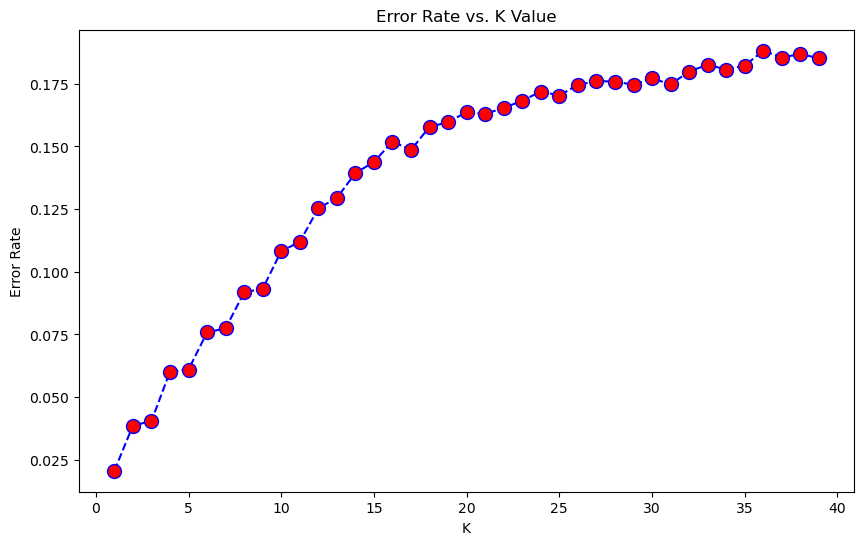

In [232]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color="blue", linestyle="dashed", marker="o",
 markerfacecolor="red", markersize=10)
plt.title("Error Rate vs. K Value")
plt.xlabel("K")
plt.ylabel("Error Rate")

In [233]:
knn_model = KNeighborsClassifier(n_neighbors=1,metric='cosine')
knn_model.fit(X_train,y_train)
pickle.dump(knn_model,open("model/knn_model_transfer_news.pkl","wb"))

In [234]:
pred = knn_model.predict(X_test)
prediction_wrong=(pred!=y_test).sum()
prediction_right=(pred==y_test).sum()

In [235]:
print(f"Wrong prediction : {prediction_wrong}")
print(f"Righ prediction : {prediction_right}")

Wrong prediction : 129
Righ prediction : 6135


In [236]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

    Negative       0.95      1.00      0.97      2125
     Neutral       1.00      0.94      0.97      2055
    Positive       0.99      1.00      1.00      2084

    accuracy                           0.98      6264
   macro avg       0.98      0.98      0.98      6264
weighted avg       0.98      0.98      0.98      6264

